# Usando la visualización como herramienta de exploración

(En primer lugar cargamos una pequeña utilidad para mostrar u ocultar las celdas)

In [35]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Mostrar/Esconder'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' siguiente celda'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

Trabajaremos con dos datasets, uno de demostración, y otro para practicar.

El primero describe los accidentes de coche en Barcelona y lo obtendremos de las bases de datos abiertas del ayuntamiento de Barcelona.

https://opendata-ajuntament.barcelona.cat/data/en/dataset/accidents-gu-bcn

cogeremos el de 2018: 2018_accidents_gu_bcn.csv

Parte del análisis está extraido o inspirado en el post de Amanda Iglesias https://towardsdatascience.com/analysis-of-car-accidents-in-barcelona-using-pandas-matplotlib-and-folium-73384240106b

El segundo describe las medallas olímpicas durante los años 1896 a 2008.

Y lo obtendremos de https://github.com/cheerfulstoic/neo4j_summer_olympics/blob/master/Summer_Olympic_medallists_1896-2008.xlsx

pero lo usaremos tambien en CSV


Para facilitar el acceso todos los datasets estan disponibles en el repositorio público https://github.com/MireiaUB/PostGraduateInfoVis (también en el privado del posgrado)

para usarlos debe vincularse su versión "raw". Por ejemplo:
https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv

In [36]:
# Tras ello instalaremos Altair con conda o pip, según vuestro entorno
# [https://altair-viz.github.io/getting_started/installation.html#installation-notebook] 


# $ conda install -c conda-forge altair vega_datasets notebook vega

# $ pip install -U altair vega_datasets notebook vega

Para empezar a trabajar observaremos un poco la distribución de variables en el dataset de accidentes. Usaremos pandas como auxiliar en el trabajo con los datos.

Observamos el dataset con pandas

In [37]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/2018_accidents_gu_bcn.csv')
df.head()

# El dataset incluye 27 columnas

list(df.columns)

hide_toggle()

Traduciremos el nombre de las columnas al castellano para facilitar su lectura excepto en las fechas, que las necesitamos en inglés para una posterior transformación

In [38]:
dfcas=df.rename(columns={"Numero_expedient": "Numero_expediente", 
                   "Codi_districte": "Codigo_distrito",
                   "Nom_districte": "Nombre_distrito",
                   "Codi_barri": "Codigo_barrio",
                   "Nom_barri": "Nombre_barrio",
                   "Codi_carrer": "Codigo_calle",
                   "Nom_carrer": "Nombre_calle",
                   "Num_postal ": "Num_postal",
                   "Descripcio_dia_setmana": "Descripcion_dia_semana",
                   "Dia_setmana": "Dia_semana",
                   "Descripcio_tipus_dia": "Descripcion_tipo_dia",
                   "Any": "year",
                   "Mes_any": "month",
                   "Nom_mes": "Nombre_mes",
                   "Dia_mes": "day",
                   "Hora_dia": "hour",
                   "Descripcio_torn": "Descripcion_turno",
                   "Descripcio_causa_vianant": "Descripcion_causa_peaton",
                   "Numero_morts": "Numero_muertos",
                   "Numero_lesionats_lleus": "Numero_lesionados_leves",
                   "Numero_lesionats_greus": "Numero_lesionados_graves",
                   "Numero_victimes": "Numero_victimas",
                   "Numero_vehicles_implicats": "Numero_vehiculos_implicados",
                   "Coordenada_UTM_X": "Coordenada_UTM_X",
                   "Coordenada_UTM_Y": "Coordenada_UTM_Y",
                   "'Longitud": "'Longitud",
                   "Latitud": "Latitud"
                  })

dfcas.head()

hide_toggle()

Observamos y eliminamos valores nulos, eliminamos columnas innecesarias

In [39]:
# Observamos valores nulos 
dfcas.info()

# Solo num_postal tiene nulos, pero no usaremos esta columna. 
# Vamos a eliminar esta y otras columnas innecesarias

dfcas.drop(['Codigo_barrio','Codigo_calle','Num_postal','Descripcion_dia_semana','Nombre_mes','Descripcion_causa_peaton','Coordenada_UTM_X','Coordenada_UTM_Y'],axis=1 ,inplace=True)

hide_toggle()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9936 entries, 0 to 9935
Data columns (total 27 columns):
Numero_expediente              9936 non-null object
Codigo_distrito                9936 non-null int64
Nombre_distrito                9936 non-null object
Codigo_barrio                  9936 non-null int64
Nombre_barrio                  9936 non-null object
Codigo_calle                   9936 non-null int64
Nombre_calle                   9935 non-null object
Num_postal                     5138 non-null object
Descripcion_dia_semana         9936 non-null object
Dia_semana                     9936 non-null object
Descripcion_tipo_dia           9936 non-null object
year                           9936 non-null int64
month                          9936 non-null int64
Nombre_mes                     9936 non-null object
day                            9936 non-null int64
hour                           9936 non-null int64
Descripcion_turno              9936 non-null object
Descripcion_caus

Usaremos el número de expediente como índice pero primero debemos limpiarlo

In [40]:
# visualización inicial
dfcas.Numero_expediente.loc[0]

# eliminamos espacios a la derecha
dfcas.Numero_expediente = dfcas.Numero_expediente.apply(lambda x: x.strip())

# visualización sin espacios
dfcas.Numero_expediente.loc[0]

# asignación como índice
dfcas.set_index('Numero_expediente', inplace=True)

# y comprovación
dfcas.loc['2018S000150']

hide_toggle()

Convertimos las fechas a formato temporal

In [41]:
# los nombres de las columnas deben ser en ingles 
# y llamarse year,month,day,hour
dfcas['fecha']=pd.to_datetime(dfcas[['year', 'month', 'day','hour']])

# eliminamos los datos originales
dfcas.drop(['hour','day','month','year'], axis=1, inplace=True)
hide_toggle()

Eliminamos duplicados

In [42]:
dfcas.duplicated().sum()

dfcas.drop_duplicates(inplace=True)
dfcas.shape

hide_toggle()

In [43]:
#y guardamos el dataset para su uso posterior como archivo externo

dfcas.to_csv('2018_accidentes_limpio.csv',index=False)

## Probemos de responder algunas preguntas con visualización

In [44]:
import altair as alt      # la librería de visualización que usaremos
from altair import datum  # para consultar un dato en particular

# Para ver los plots en Jupyter notebook usar la línea siguiente
# en Google colab comentarla para que no se ejecute
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Para nuestros gráficos usaremos la [librería Altair](https://altair-viz.github.io/), derivada de D3, y de su sucesor Vega-Lite.

Un gráfico en Altair tiene las siguientes partes básicas: <img src='anatomia-de-un-grafico.png' width="300"></img>

<h4 id="datos">Datos</h4>
<p><code style="color:#a82e1e">Altair</code> acepta <strong>datasets</strong> de 3 maneras:</p>
<ul>
  <li>un <code style="color:#cc2f1b">DataFrame</code> de <code style="color:#cc2f1b">pandas</code></li>
  <li>un objeto de clase <code style="color:#cc2f1b">Data</code> de <code style="color:#cc2f1b">altair</code></li>
  <li>datos en formato <code style="color:#cc2f1b">JSON</code> o <code style="color:#cc2f1b">csv</code> de manera directa. Esta es una opción muy recomendable porque independiza los datos de la visualización y reduce la carga de memoria.</li>
</ul>

<h4 id="marcadores">Marcas</h4>

<p>Una marca en un gráfico es la representación visual de tus datos. Actualmente <code style="color:#cc2f1b">Altair</code> ofrece las siguientes marcas :</p>

<table>
  <thead>
    <tr>
      <th>Marca</th>
      <th>Método</th>
      <th>Descripción</th>
      <th>Ejemplo</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>area</td>
      <td>mark_area()</td>
      <td>Un gráfico de area.</td>
      <td><a href="https://altair-viz.github.io/gallery/simple_stacked_area_chart.html#gallery-simple-stacked-area-chart">Simple Stacked Area Chart</a></td>
    </tr>
    <tr>
      <td>barra</td>
      <td>mark_bar()</td>
      <td>Un gráfico de barras.</td>
      <td><a href="https://altair-viz.github.io/gallery/simple_bar_chart.html#gallery-simple-bar-chart">Simple Bar Chart</a></td>
    </tr>
    <tr>
      <td>círculo</td>
      <td>mark_circle()</td>
      <td>Un diagrama de dispersión con círculos rellenos.</td>
      <td><a href="https://altair-viz.github.io/gallery/one_dot_per_zipcode.html#gallery-one-dot-per-zipcode">One Dot Per Zipcode</a></td>
    </tr>
    <tr>
      <td><em>geofigura</em></td>
      <td>mark_geoshape()</td>
      <td>Una fígura geográfica.</td>
      <td><a href="https://altair-viz.github.io/gallery/choropleth.html#gallery-choropleth">Choropleth Map</a></td>
    </tr>
    <tr>
      <td>línea</td>
      <td>mark_line()</td>
      <td>Un gráfico de líneas.</td>
      <td><a href="https://altair-viz.github.io/gallery/simple_line_chart.html#gallery-simple-line-chart">Simple Line Chart</a></td>
    </tr>
    <tr>
      <td>punto</td>
      <td>mark_point()</td>
      <td>Un diagrama de dispersión con formas de puntos configurables.</td>
      <td><a href="https://altair-viz.github.io/gallery/scatter_linked_brush.html#gallery-scatter-linked-brush">Faceted Scatter Plot with Linked Brushing</a></td>
    </tr>
    <tr>
      <td>rectángulo</td>
      <td>mark_rect()</td>
      <td>Un rectángulo relleno, usado para mapas de calor (<em>heatmaps</em>).</td>
      <td><a href="https://altair-viz.github.io/gallery/simple_heatmap.html#gallery-simple-heatmap">Simple Heatmap</a></td>
    </tr>
    <tr>
      <td>regla</td>
      <td>mark_rule()</td>
      <td>Una línea vertical u horizontal que abarca el eje.</td>
      <td><a href="https://altair-viz.github.io/gallery/candlestick_chart.html#gallery-candlestick-chart">Candlestick Chart</a></td>
    </tr>
    <tr>
      <td>cuadrado</td>
      <td>mark_square()</td>
      <td>Un diagrama de dispersión con cuadrados.</td>
      <td>N/A</td>
    </tr>
    <tr>
      <td>texto</td>
      <td>mark_text()</td>
      <td>Un diagrama de dispersián con los puntos representados con texto.</td>
      <td><a href="https://altair-viz.github.io/gallery/bar_chart_with_labels.html#gallery-bar-chart-with-labels">Simple Bar Chart with Labels</a></td>
    </tr>
    <tr>
      <td>tick</td>
      <td>mark_tick()</td>
      <td>Una línea horizontal o vertical.</td>
      <td><a href="https://altair-viz.github.io/gallery/strip_plot.html#gallery-strip-plot">Strip Plot</a></td>
    </tr>
  </tbody>
</table>

<h4 id="codificaciones">Codificaciones</h4>

<p>Para conectar la información a un elemento visual en el gráfico, <em>codificamos</em> los datos. Es el proceso de asignar valores (en este caso columnas del <strong>Dataset</strong>) a elementos posicionales (como el eje X o Y) o propiedades de tu marca (como el color o el tamaño).
    
<p> Veremos diversos ejemplos. </p>
    
<h3 id="tipos-de-datos">Tipos de Datos</h3>

<p><code style="color:#cc2f1b">Altair</code> reconoce 4 tipos de datos:</p>

<table>
  <thead>
    <tr>
      <th style="text-align: center">Tipo de datos</th>
      <th style="text-align: center">Código</th>
      <th style="text-align: left">Descripción</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="text-align: center">Cuantitativo</td>
      <td style="text-align: center">Q</td>
      <td style="text-align: left">una cantidad continua y de números reales</td>
    </tr>
    <tr>
      <td style="text-align: center">Ordinal</td>
      <td style="text-align: center">O</td>
      <td style="text-align: left">una cantidad discreta con orden intrínseco. Ej. lunes, martes, ...</td>
    </tr>
    <tr>
      <td style="text-align: center">Nominal</td>
      <td style="text-align: center">N</td>
      <td style="text-align: left">una cantidad discreta y sin orden. Ej. perro, gato, tortuga...</td>
    </tr>
    <tr>
      <td style="text-align: center">Temporal</td>
      <td style="text-align: center">T</td>
      <td style="text-align: left">un valor de tiempo o fecha</td>
    </tr>
  </tbody>
</table>

Esta explicación, ha sido adaptada de la guía   [Visualización de datos con Altair](https://cimarron.io/guia-altair/intro), en la que podeis encontrar más ejemplos y detalles. También os puede resultar de utilidad [un conjunto de notebooks realizados para demostrar las funcionalidades principales de Altair](https://github.com/altair-viz/altair-tutorial/tree/master/notebooks), creados por su autor Jake Vanderplas.

### ¿Cuál es la distribución de los accidentes a lo largo del tiempo?

#### Uno de los gráficos más usados para distribuciones es el histograma

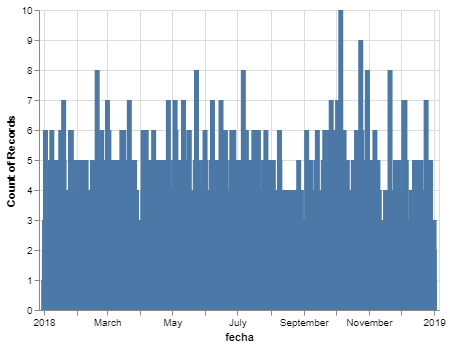

In [45]:
# Para hacer un histograma, hacemos un gráfico de barras 
# y en el  eje Y codificamos el número de elementos

alt.Chart('2018_accidentes_limpio.csv').mark_bar().encode(
    x='fecha:T',
    y='count()'
)

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px"> Ejercicio 1</h3>

Crea un histograma con las medallas por países en los juegos olímpicos.

La solución está en la siguiente celda, <em>no la muestres</em> sin haberlo intentado tú.

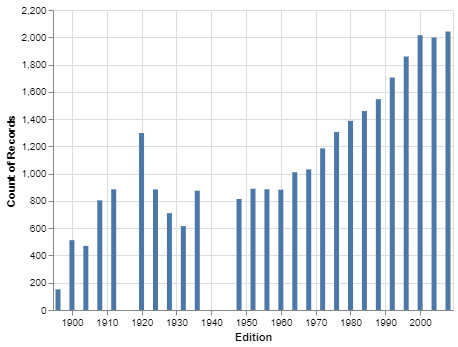

In [46]:
import pandas as pd

dfmedals = pd.read_csv('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv')
dfmedals.head()

list(dfmedals.columns)

alt.Chart('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv').mark_bar().encode(
    x='Edition:T',
    y='count()'
)

# hide_toggle()

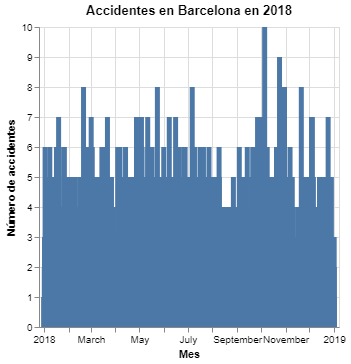

In [47]:
# Podemos mejorar el gráfico añadiendo títulos al gráfico y a los ejes
# Cuando la codificación no es "simple", 
# usamos la expresión alt.Propiedad

alt.Chart('2018_accidentes_limpio.csv',
          title="Accidentes en Barcelona en 2018"
).mark_bar().encode(
    x=alt.X('fecha:T',title="Mes"),
    y=alt.Y('count()',title="Número de accidentes")
).properties(
    width=300
)

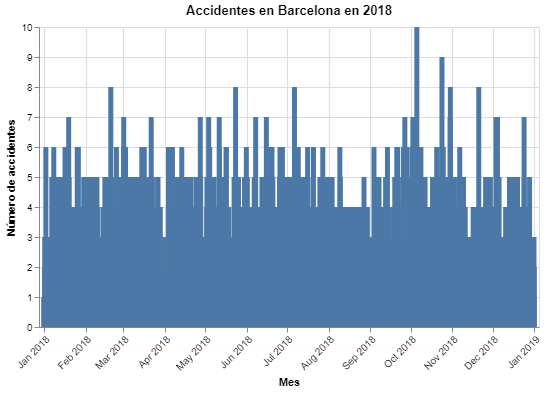

In [48]:
# Podemos mejorar también los ejes
alt.Chart('2018_accidentes_limpio.csv',
          title="Accidentes en Barcelona en 2018"
).mark_bar().encode(
    x=alt.X('fecha:T',axis = alt.Axis(labelAngle = -45, 
                    title = 'Mes', format = ("%b %Y"))),
    y=alt.Y('count()',title='Número de accidentes')
).properties(
    width=500
)

# Los formatos temporales los podeis consultar en 
# https://github.com/d3/d3-time-format#locale_format

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px"> Ejercicio 2</h3>

Mejora el histograma anterior con títulos y ejes más claros.

La solución está en la siguiente celda, <em>no la muestres</em> sin haberlo intentado tú.

In [15]:
alt.Chart('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv',
          title="Medallas por Edición"
         ).mark_bar().encode(
    x=alt.X('Edition:T',title="Edición"),
    y=alt.Y('count()',title="Número medallas")
)

hide_toggle()

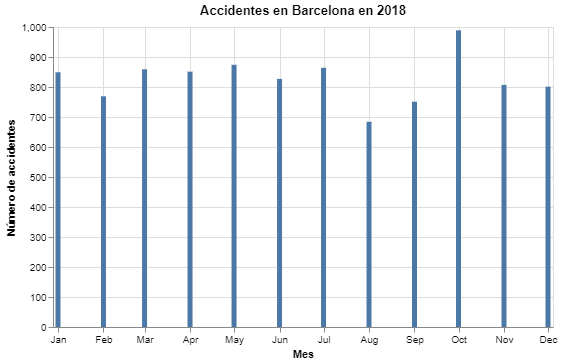

In [16]:
# En los datos temporales podemos establecer la precisión con timeUnit
# que puede tomar valores como ‘year’, ‘quarter’, ‘month’, ‘day’, ‘date’,
# ‘hours’, ‘minutes’, ‘seconds’, ‘milliseconds’
# o compuestos como ‘yearquarter’, ‘yearquartermonth’, ‘yearmonth’, 
# ‘yearmonthdate’, ‘yearmonthdatehours’, ‘yearmonthdatehoursminutes’, 
# ‘yearmonthdatehoursminutesseconds’, ‘quartermonth’, ‘monthdate’, 
# ‘monthdatehours’, ‘hoursminutes’, ‘hoursminutesseconds’, 
# ‘minutesseconds’, ‘secondsmilliseconds’

bcnmes = alt.Chart('2018_accidentes_limpio.csv',
          title="Accidentes en Barcelona en 2018"
).mark_bar().encode(
    x=alt.X('fecha:T',timeUnit = 'month',title="Mes"),
    y=alt.Y('count()',title="Número de accidentes")
).properties(
    width=500
)

bcnmes

Las visualizaciones nos permitirán hacer observaciones a las que es difícil de llegar a partir de tablas de números. Para ejemplificarlo tras cada gráfico, si es relevante, se describirán las observaciones más relevantes.

#### Observación
<p style="color:#196b49;font-style:italic">En 2018 el mes de mayor siniestralidad fue octubre, y el de menor agosto.</p>

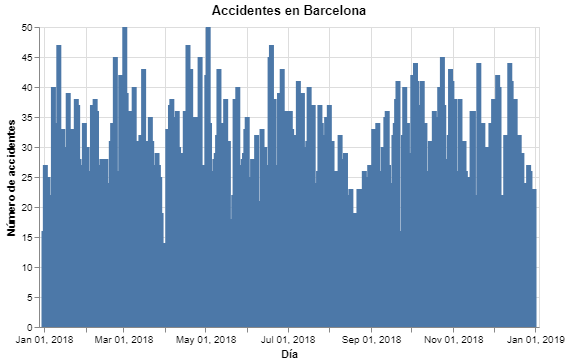

In [17]:
alt.Chart('2018_accidentes_limpio.csv',title="Accidentes en Barcelona").mark_bar().encode(
    x=alt.X('fecha:T',timeUnit='yearmonthdate',title="Día"),
    y=alt.Y('count()',title="Número de accidentes"),
    tooltip=alt.Tooltip('fecha:T',timeUnit='yearmonthdate')
).properties(
    width=500
)

#### Observación
<p style="color:#196b49;font-style:italic">Este gráfico es demasiado denso para poder hacer observaciones con sentido. Probaremos otras distribuciones.</p>

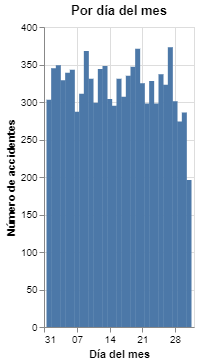

In [18]:
bcndiames = alt.Chart('2018_accidentes_limpio.csv',title="Por día del mes").mark_bar().encode(
    x=alt.X('fecha:T',timeUnit='date',title="Día del mes"),
    y=alt.Y('count()',title="Número de accidentes")
).properties(
    width=150
)

bcndiames

#### Observación
<p style="color:#196b49;font-style:italic">No parece haber un patrón en relación al día del mes</p>

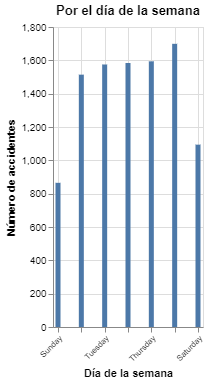

In [19]:
bcndiasemana = alt.Chart('2018_accidentes_limpio.csv',title="Por el día de la semana").mark_bar().encode(
    x=alt.X('fecha:T',timeUnit='day',title="Día de la semana",axis = alt.Axis(labelAngle = -45, labelFontSize=8, tickCount=7)),
    y=alt.Y('count()',title="Número de accidentes")
).properties(
    width=150
)

bcndiasemana

#### Observación
<p style="color:#196b49;font-style:italic">En cambio si se observa claramente un incremento de la incidentalidad los vierens, y un descenso durante el fin de semana. Estos datos seguramente son proporcionales al volumen de circulación</p>

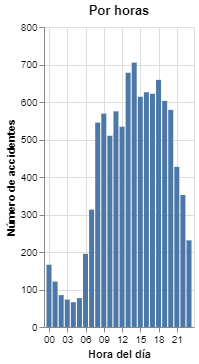

In [20]:
bcnhora = alt.Chart('2018_accidentes_limpio.csv',title="Por horas").mark_bar().encode(
    x=alt.X('fecha:T',timeUnit='hours',title="Hora del día"),
    y=alt.Y('count()',title="Número de accidentes")
).properties(
    width=150
)

bcnhora

#### Observación
<p style="color:#196b49;font-style:italic">Las horas laborales, entre 7 de la mañana y hata 8 de la tarde son las de mayor incidencia de accidentes.</p>

Podemos finalizar este análisis temporal haciendo un gráfico compuesto.

Para ello concatenaremos diversos gráficos horizontal y verticalmente

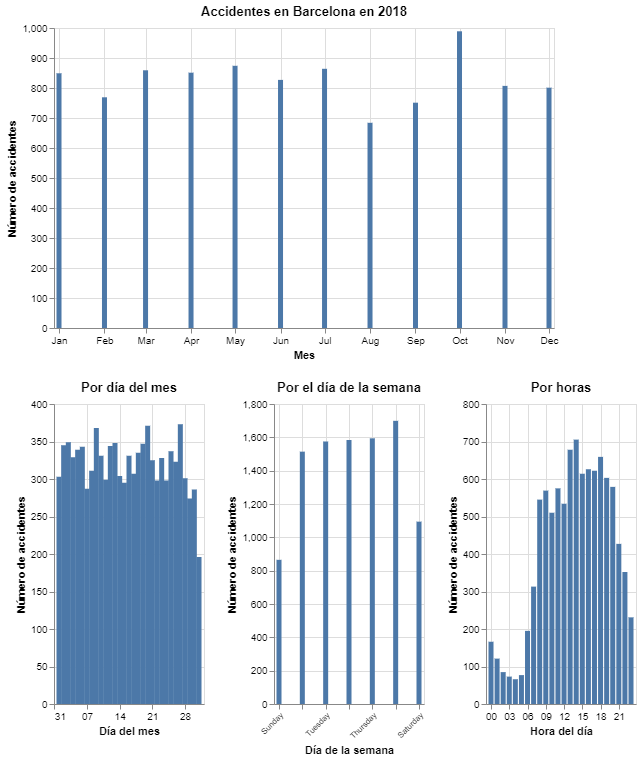

In [21]:
bcnmes & (bcndiames | bcndiasemana | bcnhora)

# & concatenación vertical
# | concatenación horizontal

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px"> Ejercicio 3</h3>

Experimenta con la distribución por diversos conceptos. Aplica filtros por países con un código parecido al siguiente(obsérva su uso en el gráfico posterior)

    .transform_filter(
        datum.Country=='Spain'
    )
    
crea la distribución de medallas en los países de Europa y concatena los diversos gráficos horizontalmente y verticalmente.

Intenta que los ejes sean equivalentes para facilitar la comparación entre los distintos países.

Una posible solución parcial está en la siguiente celda, <em>no la muestres</em> sin haberlo intentado tú.

In [22]:
Spain=alt.Chart('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv',
          title="España",
          width=150,
          height=100
         ).mark_bar().encode(
    x=alt.X('Edition:T',title=None),
    y=alt.Y('count()',scale=alt.Scale(domain=(0,200)),title=None),
    color=alt.value("red")
).transform_filter(
        datum.Country=='Spain'
)

France=alt.Chart('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv',
          title="Francia",
          width=150,
          height=100
         ).mark_bar().encode(
    x=alt.X('Edition:T',title=None),
    y=alt.Y('count()',scale=alt.Scale(domain=(0,200)),title=None),
    color=alt.value("blue")
).transform_filter(
        datum.Country=='France'
)

Spain | France

hide_toggle()

## Tendencias de distribución: gráficos de línea

Los gráficos de línea pueden enriquecer los histogramas mostrando tendencias

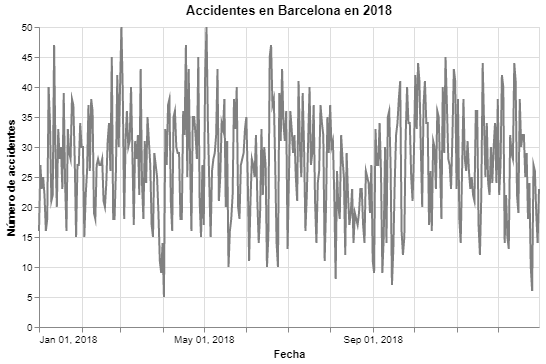

In [23]:
linea=alt.Chart('2018_accidentes_limpio.csv',
                title="Accidentes en Barcelona en 2018"
).mark_line(color="gray").encode(
    x=alt.X('fecha:T',timeUnit = 'yearmonthdate',title="Fecha"),
    y=alt.Y('count()',title="Número de accidentes")
).properties(
    width=500
)

linea


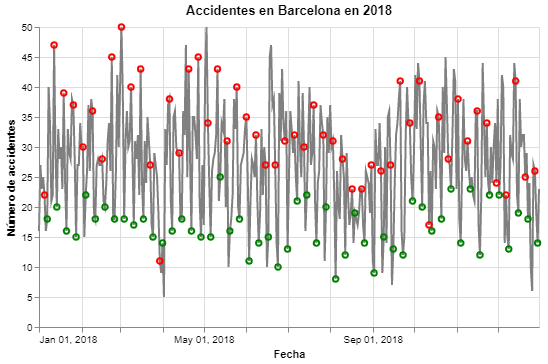

In [24]:
# También podemos combinar varios gráficos superponiendo uno sobre otro 
# siempre y cuando compartan datos y ejes
# con el operador +. 
# Hay que tener en cuenta que el orden de las capas
# es relevante. La última es la superior.

linea=alt.Chart('2018_accidentes_limpio.csv',
                title="Accidentes en Barcelona en 2018"
).mark_line(color="gray").encode(
    x=alt.X('fecha:T',timeUnit = 'yearmonthdate',title="Fecha"),
    y=alt.Y('count()',title="Número de accidentes")
).properties(
    width=500
)

viernes=alt.Chart('2018_accidentes_limpio.csv'
).mark_point(color="red").encode(
    x=alt.X('fecha:T',timeUnit = 'yearmonthdate'),
    y=alt.Y('count()'),
    tooltip=alt.Tooltip('fecha:T',timeUnit = 'yearmonthdate')
).properties(
    width=500
).transform_filter(
    datum.Dia_semana=='Dv'
)

domingo=alt.Chart('2018_accidentes_limpio.csv'
).mark_point(color="green").encode(
    x=alt.X('fecha:T',timeUnit = 'yearmonthdate'),
    y=alt.Y('count()'),
    tooltip=alt.Tooltip('fecha:T',timeUnit = 'yearmonthdate')
).properties(
    width=500
).transform_filter(
    datum.Dia_semana=='Dg'
)


linea+viernes+domingo


#### Observación
<p style="color:#196b49;font-style:italic">El patrón viernes / domingo se mantiene constante a lo largo del año salvo contadas excepciones, que se corresponden a viernes festivos -- o puente -- (5 de enero, 12 de octubre, 7 de diciembre) y a un error (30 de marzo, que es sabado aparece como viernes)</p>

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px">Ejercicio 4</h3>

Muestra la tendencia de medallas, diferenciando por ejemplo por géneros.

Una posible solución está en la siguiente celda, <em>no la muestres</em> sin haberlo intentado tú.

In [25]:
alt.Chart('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv',
          title="Medallas"
         ).mark_line().encode(
    x=alt.X('Edition:T',title="Edición"),
    y=alt.Y('count()',title="Número medallas"),
    color=alt.Color('Gender:N',title="Género")
)

hide_toggle()

## Boxplot

Otro gráfico común para distribuciones es el boxplot. Como nuestro dataset no facilita esta visualización, reproducimos aquí el [boxplot de la galería de Altair](https://altair-viz.github.io/gallery/boxplot.html), podeis observar directamente [el dataset](https://vega.github.io/vega-datasets/data/population.json)  para ver el patrón de datos.


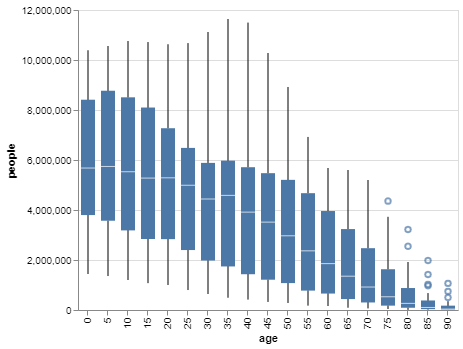

In [26]:
from vega_datasets import data

source = data.population.url

alt.Chart(source).mark_boxplot().encode(
    x='age:O',
    y='people:Q'
)

## Correlaciones

Para ver la relación entre dos o más variables podemos usar

+ Gráficos de dispersión
    - Con el tamaño codificando una tercera variable
+ Gráficos de barra con una línea de ratio
+ Heatmaps, para datasets muy densos

### Gráficos de dispersión (scatterplots)

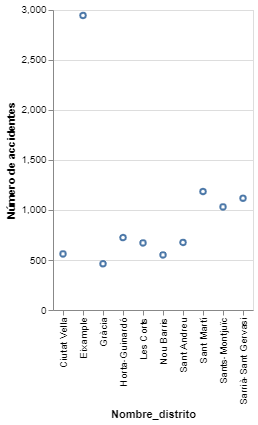

In [27]:
alt.Chart('2018_accidentes_limpio.csv').mark_point(
).encode(
    x='Nombre_distrito:N',
    y=alt.Y('count()',title="Número de accidentes",stack=None),
    tooltip=['count()','Nombre_distrito:N']
)

#### Observación
<p style="color:#196b49;font-style:italic">Eixample tiene con diferencia la mayor siniestralidad, Gracia la menor, y podríamos agrupar Sant Martí, Sants-Montjuic, i Sarrià-Sant Gervasi en un cluster</p>

### Gráficos de dispersión con tamaño (Bubble charts)

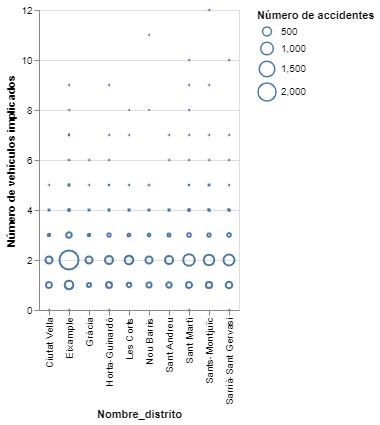

In [28]:
alt.Chart('2018_accidentes_limpio.csv').mark_point(
).encode(
    x='Nombre_distrito:N',
    y=alt.Y('Numero_vehiculos_implicados:Q',title="Número de vehículos implicados"),
    size=alt.Size('count()',legend=alt.Legend(title="Número de accidentes")),
    tooltip=['count()','Nombre_distrito:N','Numero_vehiculos_implicados:Q']
)

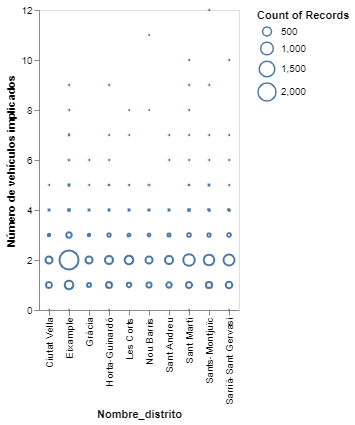

In [29]:
# Podemos mejorar el gráfico quitando la trama 

alt.Chart('2018_accidentes_limpio.csv').mark_point(
).encode(
    x='Nombre_distrito:N',
    y=alt.Y('Numero_vehiculos_implicados:Q',title="Número de vehículos implicados"),
    size='count()',
    tooltip=['count()','Nombre_distrito:N','Numero_vehiculos_implicados:Q']
).configure_axis(
    grid=False
)

#### Observación
<p style="color:#196b49;font-style:italic">No se observan diferencias entre el número de accidentes y los vehículos involucrados. En todos los barrios la mayoría de accidentes involucra 2 coches, algunos 1 o 3, y pocos accidentes involucran más coches.</p>

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px">Ejercicio 5</h3>

Existe una correlación entre la ciudad de celebración y las medallas obtenidas por país? observa el caso de España y Francia.

Una posible solución está en la siguiente celda, <em>no la muestres</em> sin haberlo intentado tú.

In [30]:
alt.Chart('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv',
          title="Medallas"
         ).mark_point().encode(
    x=alt.X('City:N',title="Ciudad de celebración"),
    y=alt.Y('Country:N',title="País"),
    size='count()',
    tooltip='count()'
).transform_filter(
    (datum.Country =='Spain') | (datum.Country =='France')
)

hide_toggle()

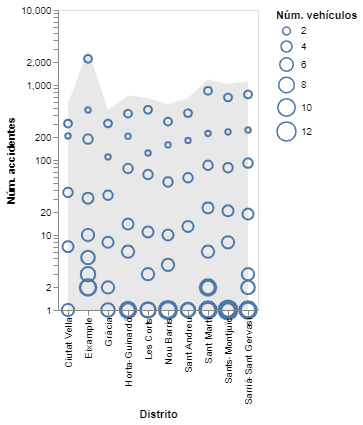

In [31]:
# y superponiendo un gráfico de area con los totales
# aunque para observar mejor los tamaños usaremos una escala logarítmica

linea = alt.Chart('2018_accidentes_limpio.csv').mark_area(color="lightgray",opacity=0.5
).encode(
    x='Nombre_distrito:N',
    y=alt.Y('count()',scale=alt.Scale(type='log'))
)

scatter = alt.Chart('2018_accidentes_limpio.csv').mark_point(
).encode(
    x=alt.X('Nombre_distrito:N',title="Distrito"),
    y=alt.Y('count()',title="Núm. accidentes",scale=alt.Scale(type='log')),
    size=alt.Size('Numero_vehiculos_implicados:Q',legend=alt.Legend(title="Núm. vehículos")),
    tooltip=['count()','Nombre_distrito:N','Numero_vehiculos_implicados:Q']
)



(linea + scatter).configure_axis(
    grid=False
)

### Gráficos de barra con una línea de ratio

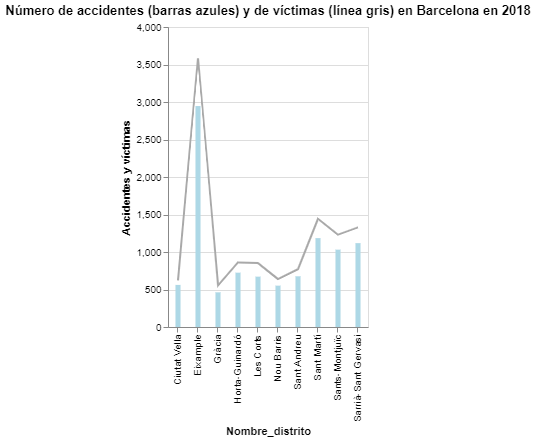

In [32]:
bar = alt.Chart('2018_accidentes_limpio.csv',
               title="Número de accidentes (barras azules) y de víctimas (línea gris) en Barcelona en 2018"
               ).mark_bar(color="lightblue",width=5).encode(
    x='Nombre_distrito:N',
    y=alt.Y('count()',title='Accidentes y víctimas')
)

line = alt.Chart('2018_accidentes_limpio.csv').mark_line(color="darkgray").encode(
    x='Nombre_distrito:N',
    y=alt.Y('sum(Numero_victimas):Q',axis=None)
)

# Altair contiene las siguientes agregaciones por defecto:
# ‘argmax’, ‘argmin’, ‘average’, ‘count’, ‘distinct’, ‘max’, ‘mean’, ‘median’, ‘min’, 
# ‘missing’, ‘q1’, ‘q3’, ‘ci0’, ‘ci1’, ‘stderr’, ‘stdev’, ‘stdevp’, ‘sum’, ‘valid’, 
# ‘values’, ‘variance’, ‘variancep’

bar + line


#### Observación
<p style="color:#196b49;font-style:italic">Existe una relación directamente proporcional entre el número de accidentes y el número de víctimas, aunque este último es siempre superior, es decir de media hay más de una víctima por accidente.</p>

### Heatmaps

Los heatmaps son un tipo de gráficos muy útiles para mostrar relaciones quantitativas entre dos variables en datasets con alta densidad de datos.

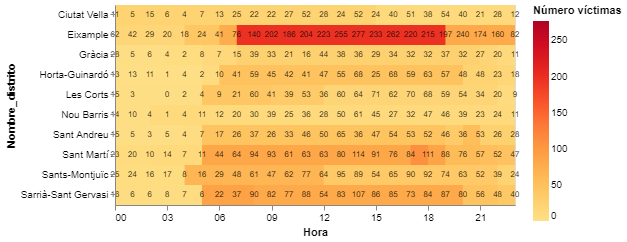

In [33]:
grid=alt.Chart('2018_accidentes_limpio.csv').mark_rect().encode(
    x=alt.X('fecha:T',timeUnit ='hours',title="Hora"),
    y='Nombre_distrito:N',
    color=alt.Color('sum(Numero_victimas):Q',
                    scale=alt.Scale(scheme='yelloworangered'),
                    legend=alt.Legend(title="Número víctimas",
                                      format="d"))
)

text = alt.Chart('2018_accidentes_limpio.csv').mark_text(size=8).encode(
    x=alt.X('fecha:T',timeUnit ='hours'),
    y='Nombre_distrito:N',
    text=alt.Text('sum(Numero_victimas):Q',format="d"),
)

grid + text

# Más esquemas de colores en https://vega.github.io/vega/docs/schemes 

#### Observación
<p style="color:#196b49;font-style:italic">Este gráfico corrobora nuestra observación sobre el Eixample y muestra el mismo patrón de horas en todos los barrios.</p>

<h3 style="border-left:6px solid silver;background-color:#eeeeee;padding-left:10px">Ejercicio 6</h3>

Existe una correlación entre la ciudad de celebración y las medallas obtenidas por país.

Una posible solución está en la siguiente celda, <em>no la muestres</em> sin haberlo intentado tú.

In [34]:
alt.Chart('https://raw.githubusercontent.com/MireiaUB/PostGraduateInfoVis/master/Summer_Olympic_medallists_1896-2008.csv',
          title="Medallas"
         ).mark_rect().encode(
    x=alt.X('City:N',title="Ciudad de celebración"),
    y=alt.Y('Country:N',title="País"),
    color=alt.Color('count()',legend=alt.Legend(orient="top"))
)

hide_toggle()